# Information content approximation for neural network reconsturction 



This notebook investigates the error that comes from the missing information when only the data between the rapid moorings can be used.
For the reconstruction with Neural Networks we aimed for reconstructing the geostrophic AMOC at 1000m depth with the density information at the rapid mooring positions.
Therefore we extracted the insitu density from those positions in the VIKING20X.L46-KFS003 simulation and fed them through a NN with the goal to reconstruct the geostrophic shear computed by the CDFTools.
As the results were not reaching sufficient scores the question arised for the reason and this notebook will highlight what linarly is possible with the density information between the moorings and only with the moorings. 
Therefore we implemented the CDF methods one by one in Python and use them only on the geostrophic velocities gridboxed within the mooring profiles.

## Input data 

We calculate the AMOC from the pre calculated insitu density by the CDF tools. 

In [2]:
# Utilities
import xarray as xr
import numpy as np
from pathlib import Path
import gsw
from xarray import open_mfdataset, open_dataset
from matplotlib import pyplot as plt



# Utilities 
def find_grid_files(grid_type, years, nest, model, delta_t, folder = 'output'): 
    experiment_path = Path('/gxfs_work/geomar/smomw355/model_data/ocean-only/')
    nest_part = '1_' if nest else '' 

    if len(grid_type) < 2:
        grid_type = f'grid_{grid_type}'

    grid_files = (experiment_path / model / 'nemo' / folder).glob(f'{nest_part}{model}_{delta_t}_*_*_{grid_type}.nc')
    grid_files = list(grid_files)
    
    result_files = []
    for file in grid_files:
        start_year = int(str(file).split('/')[-1].split('_')[- (3 + grid_type.count('_'))][:4])
        
        if (years[0] is None or start_year >= years[0]) and \
           (years[1] is None or start_year < years[1]):
            result_files.append(file)
    
    return sorted(result_files)

def load_dataset_from_grid_type(grid_type, years, nest, model, delta_t, chunks = {"time_counter" : 2,"y": 2, "x": None}, **kwargs):
    files_list = find_grid_files(grid_type, years, nest, model, delta_t, **kwargs)
    grid = open_mfdataset(
        files_list, # type: ignore
        chunks= chunks,
        combine='by_coords'
    )
    return grid

def load_masks(nest, model):

    if str.startswith(model, 'VIKING20X.L46-KFS003'):
        # All the mask for the long runs VIKING20X.L46-KFS003-2nd, ... are placed in the original experiment
        model = 'VIKING20X.L46-KFS003' 
    
    nest_part = '1_' if nest else ''
    
    mask_mesh = open_dataset(
        f'/gxfs_work/geomar/smomw355/model_data/ocean-only/{model}/nemo/suppl/{nest_part}mesh_mask.nc',
        decode_cf=False,
        chunks={'y': 100, 'x':100, 'z': -1},
    )

    if model == 'VIKING20X.L46-KFS003' and not nest:
        nest_part = 'ori_'

    mask_glo = open_dataset(
        f'/gxfs_work/geomar/smomw355/model_data/ocean-only/{model}/nemo/suppl/{nest_part}new_maskglo.nc',
        decode_cf=False,
        chunks={'Y':100, 'X':100, 'z': -1}
    )

    mask_mesh = mask_mesh.squeeze()
    mask_glo = mask_glo.rename({'X':'x', 'Y':'y'}).squeeze() # Rename coordinates to have the same name as the data file
    
    return mask_mesh, mask_glo



In [3]:
# Open insitu density
rho = xr.open_dataset('/gxfs_work/geomar/smomw507/geomar/amoc-reconstruction/data/cdfgeostrophic/1_VIKING20X.L46-KFS003_1m_19700101_19701231_dens.nc', chunks={'y': 100, 'x':100, 'time_counter': 1})
rho = rho.rename({"deptht": "z"})
rho = rho.assign_coords(x=np.arange(rho.dims["x"]), y=np.arange(rho.dims["y"]))

rho = rho.vosigmainsitu

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Load masks of the VIKING20X simualtion 
ds_m, ds_mask = load_masks(True, 'VIKING20X.L46-KFS003')
ds_m = ds_m.assign_coords(x=np.arange(ds_m.dims["x"]), y=np.arange(ds_m.dims["y"]))
ds_mask = ds_mask.assign_coords(x=np.arange(ds_mask.dims["x"]), y=np.arange(ds_mask.dims["y"]))

In [5]:
# Load the data into memory 
dens_all_t = rho.transpose('time_counter', 'x', 'y', 'z').values
tmask = ds_m.tmask.transpose('x', 'y', 'z').values
umask = ds_m.umask.transpose('x', 'y', 'z').values
vmask = ds_m.vmask.transpose('x', 'y', 'z').values
e1u = ds_m.e1u.transpose('x', 'y').values
e1v = ds_m.e1v.transpose('x', 'y').values
e3v = ds_m.e3v_0.transpose('x', 'y', 'z').values * vmask
gphiv = ds_m.gphiv.transpose('x', 'y').values
tmaskatl = ds_mask.tmaskatl.transpose('x', 'y').values

## Calculate the geostrohpic shear


We use the one by one code from the CDF tools to calculate the geostrophic velocities for the nest configuration. 
Also we use those velocities to integrate the transport out of those velocities for the ground truth.

In [6]:
rpi = np.arccos(-1)

zcoef = 2*2*rpi/( 24.0 * 3600. )* np.sin ( rpi * gphiv /180.0)
zcoef = np.where(np.abs(gphiv) > 5, zcoef, np.nan)

zcoef = np.where(zcoef != 0, -9.81 / 1025.0 / zcoef, 0.0)

In [7]:
amoc = np.empty(shape = (dens_all_t.shape[0], dens_all_t.shape[2], dens_all_t.shape[3]))
dmoc_alongx_allt = np.empty_like(dens_all_t)
for ti, dens in enumerate(dens_all_t): 

    diff = np.diff(dens, axis = 0)

    # multiply elementwise with the u mask and divide by the width of the u box
    diff = (np.nan_to_num(diff) * umask[:-1, :, :]) / e1u[:-1, :, np.newaxis]

    drho = np.zeros_like(dens)
    drho[1:-1, :-1] = diff[:-1, :-1] + diff[1:, :-1] + diff[:-1, 1:] + diff[1:, 1:] 


    zmsv = np.ones_like(dens)
    zmsv[1:, :-1] =umask[1:, :-1] + umask[:-1, :-1] + umask[1:, 1:] + umask[:-1, 1:]
    zmsv = np.where(zmsv > 0, 1 / zmsv, 1)




    dvgeo = drho * zcoef[:,:,np.newaxis] * zmsv * e3v * tmaskatl[:, :, np.newaxis]

    dvgeo = np.where(vmask == 1, dvgeo, np.nan)
    dvgeo = np.nancumsum(dvgeo[..., ::-1], axis = -1)[..., ::-1]

    # move to v level 
    zv = np.zeros_like(dvgeo)
    for zk in range(dvgeo.shape[2] -1, -1, -1):
        if zk == dvgeo.shape[2] -1:
            zv[:,:,zk] = .5 * dvgeo[:,:,zk]
        else:
            zv[:,:,zk] = .5 * (dvgeo[:,:,zk] + dvgeo[:,:,zk + 1])


    zv = np.where(vmask == 1, zv, np.nan)

    dvbt = np.nansum(e3v * zv, axis = -1)
    hdep = np.nansum(e3v, axis = -1)


    dvbt = np.where(hdep == 0, 0, dvbt / hdep)
    dvbt = np.where(tmaskatl == 1, dvbt, np.nan)

    dmoc_sh = -e1v[:, :, np.newaxis] * e3v * zv * tmaskatl[:, :, np.newaxis]
    dmoc_btw = -dvbt[:, :, np.newaxis] * e1v[:, :, np.newaxis] * e3v


    dmoc_sh_x = dmoc_sh - dmoc_btw
    dmoc_sh = dmoc_sh - dmoc_btw

    dmoc_sh = np.nansum(dmoc_sh, axis = 0)
    dmoc_sh = np.nancumsum(dmoc_sh[:, ::-1], axis = 1)[:, ::-1] / 1e6

    amoc[ti] = dmoc_sh
    dmoc_alongx_allt[ti] = dmoc_sh_x

/scratch/SlurmTMP/smomw507.11140774/ipykernel_2545929/1345325902.py:16: RuntimeWarning: divide by zero encountered in divide
  zmsv = np.where(zmsv > 0, 1 / zmsv, 1)
/scratch/SlurmTMP/smomw507.11140774/ipykernel_2545929/1345325902.py:41: RuntimeWarning: invalid value encountered in divide
  dvbt = np.where(hdep == 0, 0, dvbt / hdep)


The variable `amoc` contains the tranport per time.
The variable `dmoc_alongx_allt` contains the transport for each grid box. The geostorphic velocity multiplied by the area without the integral.

## Calculate the geostrophic transport between the moorings


For this calculation we use the nortward transport saved in `dmoc_alongx_allt` to calculate only those transport the is between mooring profiles. It is based on the high resolution grid transport and not only on the profiles yet. We assume here that the transport below the sections and east and west to them is 0. 

In [8]:
# mooring setup 
mooring_positions = [
    [26.52,-76.74],
    [26.50,-76.50],
    [26.99,-16.23],
    [24.52,-50.57],
    [24.52,-41.21]
]


longitudes = ds_m.nav_lon
latitudes = ds_m.nav_lat

from scipy.spatial import cKDTree

tree = cKDTree(np.stack([latitudes.values.ravel(), longitudes.values.ravel()], axis = 1))

distances, indices = tree.query(mooring_positions)

indices = np.unravel_index(indices, longitudes.values.shape)

mooring_indices_y = indices[0]
mooring_indices_x = indices[1]

This figure shows the areas that are wrapped by the mooring profiles. The areas within the read boxes are part of the calculation. 

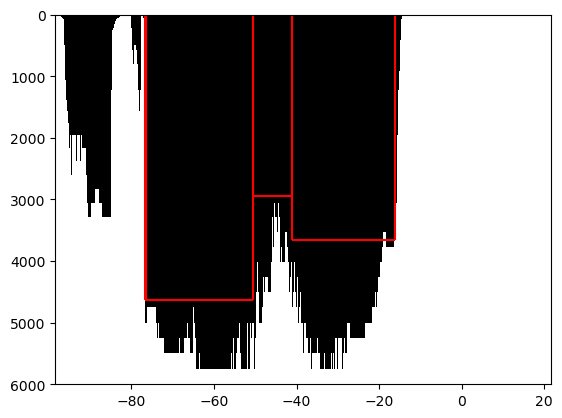

In [10]:
# area figure
mooring_pairs = [(0,1), (1,3), (3,4), (4,2)]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.pcolormesh(ds_m.nav_lon.isel(y = 1270).values, ds_m.nav_lev.values, 1 - ds_m.tmask.isel(y = 1270).values, cmap = 'gray')

for section_i, (mooring_i, mooring_j) in enumerate(mooring_pairs):
    non_blocked_depth = (1 - ds_m.tmask).isel(y = 1270, x = slice(mooring_indices_x[mooring_i]+1, mooring_indices_x[mooring_j])).sum('x').values

    last_empty_cell_index  = np.max(np.argwhere(non_blocked_depth <  .05 * (mooring_indices_x[mooring_j]-  mooring_indices_x[mooring_i])))

    # ax.vlines(mooring_indices_x[mooring_i], ymin = 0, ymax = 50, color = 'r')
    ax.vlines(ds_m.nav_lon.isel(y = 1270, x = mooring_indices_x[mooring_i]).values, ymin = 0, ymax = ds_m.nav_lev.isel(z = last_empty_cell_index).values, color = 'r')
    ax.vlines(ds_m.nav_lon.isel(y = 1270, x = mooring_indices_x[mooring_j]).values, ymin = 0, ymax = ds_m.nav_lev.isel(z = last_empty_cell_index).values, color = 'r')


    ax.hlines( ds_m.nav_lev.isel(z = last_empty_cell_index).values, xmin = ds_m.nav_lon.isel(y = 1270, x = mooring_indices_x[mooring_i]).values, xmax = ds_m.nav_lon.isel(y = 1270, x = mooring_indices_x[mooring_j]).values, color = 'r')

ax.invert_yaxis()

In [11]:
# calculate the mooring transport

npk = dmoc_alongx_allt.shape[-1]
npt = dmoc_alongx_allt.shape[0]
npiglo = dmoc_alongx_allt.shape[1]

transport = np.zeros(shape = (npt,len(mooring_pairs), npk))
explained_mooring_transport_per_x = np.zeros(shape = (npt,len(mooring_pairs), npiglo, npk))

last_empty_cell_indices = []

for section_i, (mooring_i, mooring_j) in enumerate(mooring_pairs):
    mean_y_index = (mooring_indices_y[mooring_i] + mooring_indices_y[mooring_j]) // 2

    distance = ds_m.e1u.isel(y = mean_y_index, x = slice(mooring_indices_x[mooring_i], mooring_indices_x[mooring_j])).sum('x').values


    non_blocked_depth = (1 - ds_m.tmask).isel(y = 1270, x = slice(mooring_indices_x[mooring_i]+1, mooring_indices_x[mooring_j])).sum('x').values

    last_empty_cell_index  = np.max(np.argwhere(non_blocked_depth <  .1 * (mooring_indices_x[mooring_j]-  mooring_indices_x[mooring_i])))
    last_empty_cell_indices.append(last_empty_cell_index)
    print(last_empty_cell_index)
    # last_empty_cell_index = npk-1

    dmoc_sh_within_moorings = dmoc_alongx_allt[:, mooring_indices_x[mooring_i]:mooring_indices_x[mooring_j]]
    print('dmoc_sh_within_moorings shape', dmoc_sh_within_moorings.shape)

    cumsum = np.nancumsum(dmoc_sh_within_moorings[..., :last_empty_cell_index+1][..., ::-1], axis = -1)[..., ::-1] / 1e6
    print('cumsum shape', cumsum.shape)

    explained_mooring_transport_per_x[:, section_i, mooring_indices_x[mooring_i]:mooring_indices_x[mooring_j], :last_empty_cell_index+1] = cumsum[...,mean_y_index,:]
    transport[:, section_i, :last_empty_cell_index+1] = np.nansum(cumsum[...,mean_y_index,:], axis = 1)

40
dmoc_sh_within_moorings shape (12, 5, 2499, 46)
cumsum shape (12, 5, 2499, 41)
41
dmoc_sh_within_moorings shape (12, 519, 2499, 46)
cumsum shape (12, 519, 2499, 42)
34
dmoc_sh_within_moorings shape (12, 187, 2499, 46)
cumsum shape (12, 187, 2499, 35)
36
dmoc_sh_within_moorings shape (12, 499, 2499, 46)
cumsum shape (12, 499, 2499, 37)


This figure shows the full cdf tools transport in blue and the transport estimated by the geostorphic velocities between the moorings. As the neural network only has the mooring information this estmation shows a lower bound of how well the gesotrophic AMOC can be reconstructed in a linear manner.

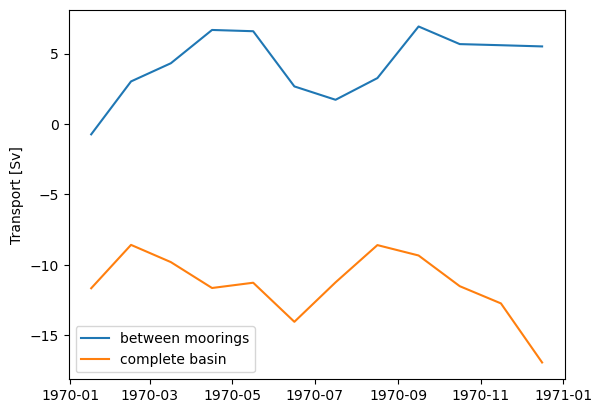

In [12]:
#transport figure
plt.plot(rho.time_counter.values,np.sum(transport, axis = 1)[:,  24], label = 'between moorings')
plt.plot(rho.time_counter.values,amoc[:, 1273,24], label = 'complete basin')

plt.ylabel('Transport [Sv]')
plt.legend()

# Geostorphic Mean within moorings + Mean of the rest 

As neural networks could learn a constant offset we add the mean transport of all the not included boxes to the gestrophic calculation.
The mask shows in yellow the regions that are not included in the caclulation for the AMOC in 1060m depth.
Adding the tranpsort in this boxes and average them for the year 1970 the mean offset are -5.6 Sv.

In the last figure this offset is added to the calculates transport and the difference to the cdf tools AMOC is shown.
The difference is between 5 and 15 Sverdrup showing a large portion of the signal that is missing in the caluclation.


In [46]:


# Calculate the mask for those boxes that are not within the mooring

mask = np.mask = np.ones(shape = (npiglo, npk))

target_depth = 24

mask[:, :target_depth] = 0

for last_used_box, (mooring_i, mooring_j) in zip(last_empty_cell_indices, mooring_pairs):

    mask[mooring_indices_x[mooring_i]:mooring_indices_x[mooring_j], :last_used_box + 1] = 0


mask = mask * np.where(tmask[:, 1270] == 0, np.nan, 1)


# Calculate the transport that is not explained by the mooring

masked_transport = dmoc_alongx_allt[:, :, 1273] * mask[np.newaxis]


mean_transport_deeper_than_target = np.nanmean(masked_transport, axis = 1)


mean_transport_deeper_than_target_integrated = np.mean(np.cumsum(np.nansum(masked_transport, axis = 1)[:, ::-1], axis = 1)[:, ::-1], axis = 0) / 1e6




/scratch/SlurmTMP/smomw507.11140774/ipykernel_2545929/358724737.py:22: RuntimeWarning: Mean of empty slice
  mean_transport_deeper_than_target = np.nanmean(masked_transport, axis = 1)


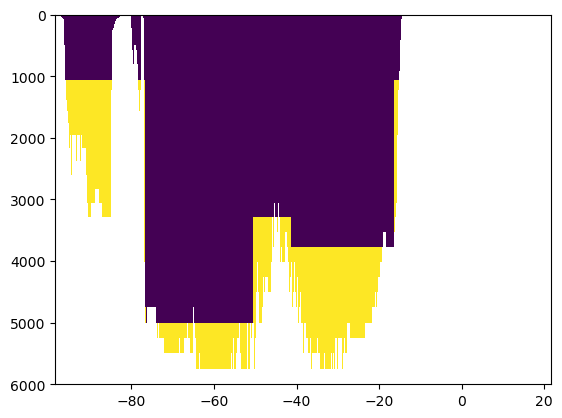

In [66]:
# mask figure
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.pcolormesh(   ds_m.nav_lon.isel(y = 1270), np.concatenate([[], ds_m.nav_lev.values]),mask[:].T)
ax.invert_yaxis()

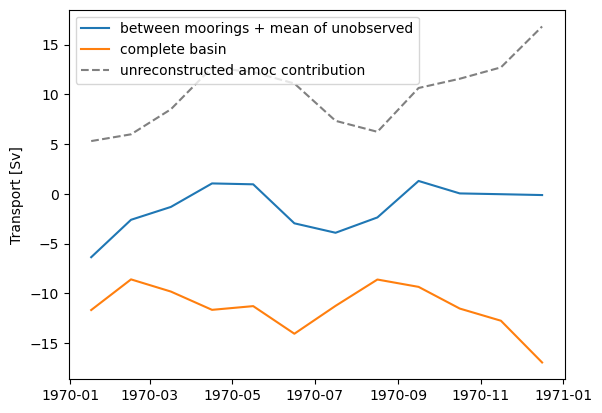

In [72]:
#transport figure with mean estimation
# plt.plot(rho.time_counter.values,np.sum(transport, axis = 1)[:,  24], label = 'between moorings')
plt.plot(rho.time_counter.values,(np.sum(transport, axis = 1) + mean_transport_deeper_than_target_integrated[np.newaxis])[:,  24], label = 'between moorings + mean of unobserved')
plt.plot(rho.time_counter.values,amoc[:, 1273,24], label = 'complete basin')

plt.plot(rho.time_counter.values,(np.sum(transport, axis = 1) + mean_transport_deeper_than_target_integrated[np.newaxis])[:,  24] - amoc[:, 1273,24], label = 'unreconstructed amoc contribution', linestyle = '--', color = 'gray')

plt.ylabel('Transport [Sv]')
plt.legend()
